# Face Generation using DCGAN


In this notebook a simple deep convolutioal gan is implemented


## Table Of Content

1. [Setup](#setup)
   1. [Set Parameter](#set-parameter)
   2. [Prepare Data](#prepare-data)
2. [Initialize GAN](#initialize-generator-and-discrimintor)
3. [Train GAN](#train-model)
4. [Evaluate](#evaluate)


## Imports


In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from tqdm import tqdm

from src.components import Discriminator, Generator

In [2]:
# to use gpu acceleration on mac uncomment the following line
device = torch.device(
    "mps"
    if torch.backends.mps.is_available() and torch.backends.mps.is_built()
    else "cpu"
)
# to use gpu acceleration on windows uncomment the following line
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# set random seed for reproducibility
np.random.seed(42)

mps


## Setup


### Set Parameter


In [3]:
# model hyperparameters
learning_rate = 2e-4
batch_size = 128
img_size = 64
channels = 3
z_dim = 100
epochs = 10

# data parameters
data_path = "./data/"
val_set_size = 0.3

### Prepare Data


In [4]:
transform = transforms.Compose(
    [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
# load images
data = ImageFolder(root=data_path, transform=transform)
idx = np.random.permutation(len(data))

# split data into train and validation
split = int(np.floor(val_set_size * len(data)))
train_idx, val_idx = idx[split:], idx[:split]

# create data loaders
train_sampler = SubsetRandomSampler(train_idx)
dl = DataLoader(data, batch_size=batch_size, sampler=train_sampler)

In [5]:
img = data[0]
img[0].shape

torch.Size([3, 64, 64])

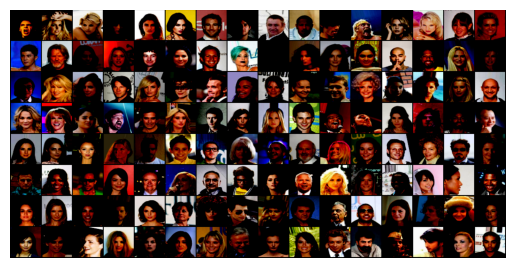

In [6]:
# select random batch of images to display
for images, _ in dl:
    images = images.reshape(images.size(0), channels, img_size, img_size)
    torchvision.utils.save_image(
        images, os.path.join(data_path, "real_images.png"), nrow=16
    )
    break

# display image
img = Image.open(os.path.join(data_path, "real_images.png"))
plt.imshow(img)
plt.axis("off")
plt.show()

## Initialize Generator and Discrimintor


In [7]:
gen = Generator(z_dim=z_dim, img_channels=channels, features=img_size).to(device)
gen.init_weights()

disc = Discriminator(img_channels=channels, features=img_size).to(device)
disc.init_weights()

In [8]:
g_optimizer = optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))
d_optimizer = optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))
loss = nn.BCELoss()

## Train Model


In [9]:
losses_disc = list()
losses_gen = list()

for epoch in range(epochs):

    for image, _ in tqdm(dl, total=len(dl)):
        batch = image.size(0)
        image = image.to(device)

        # train discriminator
        # create fake image
        noise = torch.randn(batch, z_dim, 1, 1).to(device)
        fake_image = gen(noise)
        disc_real = disc(image).reshape(-1)
        disc_fake = disc(fake_image.detach()).reshape(-1)

        # calculate losses
        loss_disc_real = loss(disc_real, torch.ones_like(disc_real))
        loss_disc_fake = loss(disc_fake, torch.zeros_like(disc_fake))
        disc_loss = (loss_disc_real + loss_disc_fake) / 2

        # perform backpropagation and optimization
        disc.zero_grad()
        disc_loss.backward()
        d_optimizer.step()

        # train generator
        output = disc(fake_image).reshape(-1)
        g_loss = loss(output, torch.ones_like(output))

        gen.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # save losses to list
        losses_disc.append(disc_loss.item())
        losses_gen.append(g_loss.item())

    print(f"Epoch [{epoch+1}/{epochs}] Loss D: {disc_loss:.4f}, Loss G: {g_loss:.4f}")

 15%|█▍        | 161/1108 [01:20<07:52,  2.00it/s]

## Evaluate


### Plot Losses


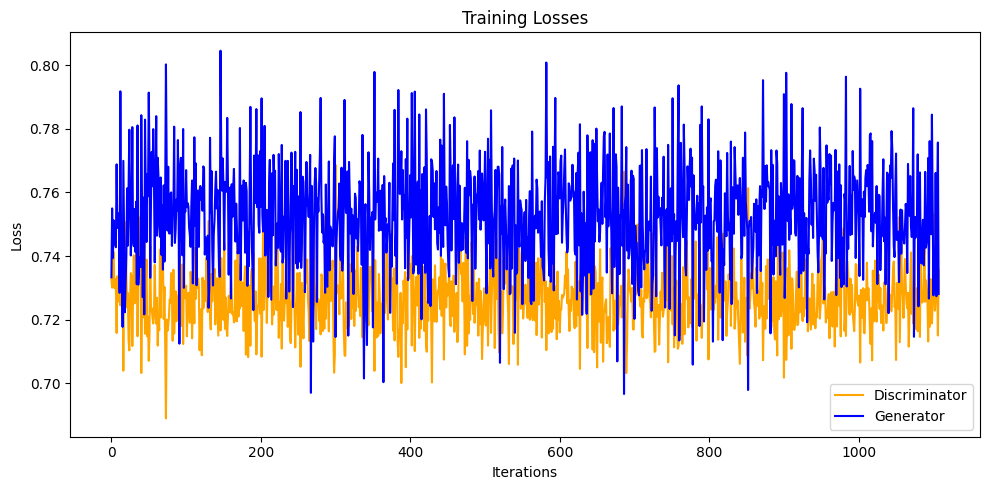

In [ ]:
fig, axes = plt.subplots(figsize=(10, 5))
axes.plot(losses_disc, label="Discriminator", color="orange")
axes.plot(losses_gen, label="Generator", color="blue")

axes.set_xlabel("Iterations")
axes.set_ylabel("Loss")

axes.set_title("Training Losses")

axes.legend()

fig.tight_layout()

### Display Generated Images


In [ ]:
with torch.no_grad():
    noise = torch.randn(64, z_dim, 1, 1).to(device)
    fake_image = gen(noise)
    save_image(fake_image, os.path.join(data_path, "fake_image.png"), nrow=8)

# display image
img = Image.open(os.path.join(data_path, "fake_image.png"))
plt.imshow(img)
plt.axis("off")
plt.show()